In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(0)  # Set seed for reproducibility

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [140]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128)  # Input: 784 pixels → Hidden: 128 neurons
        self.l3 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64 neurons
        self.l4 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10 (digits 0-9)

    def forward(self, im):
        im = im.view(-1, 28*28)
        print(im.shape)
        x = F.relu(self.l2(im))
        y = F.relu(self.l3(x))
        y = self.l4(y)
        return y

# Initialize model
model = MNIST_Net()
#model.load_state_dict(torch.load("model_weights3.pth"))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



MNIST_Net(
  (l2): Linear(in_features=784, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)

In [141]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        break
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
#torch.save(model.state_dict(), "./model_weights3.pth")


torch.Size([64, 784])
Epoch 1/5, Loss: 0.0984
torch.Size([64, 784])
Epoch 2/5, Loss: 0.0984
torch.Size([64, 784])
Epoch 3/5, Loss: 0.0984
torch.Size([64, 784])
Epoch 4/5, Loss: 0.0984
torch.Size([64, 784])
Epoch 5/5, Loss: 0.0984
Training complete!


In [95]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 96.71%


In [96]:
total_weights = sum(p.numel() for name, p in model.named_parameters() if "weight" in name)
total_biases = sum(p.numel() for name, p in model.named_parameters() if "bias" in name)

print(f"Total Weights: {total_weights}")
print(f"Total Biases: {total_biases}")
print(f"Total Parameters: {total_weights + total_biases}")


Total Weights: 109184
Total Biases: 202
Total Parameters: 109386


109184


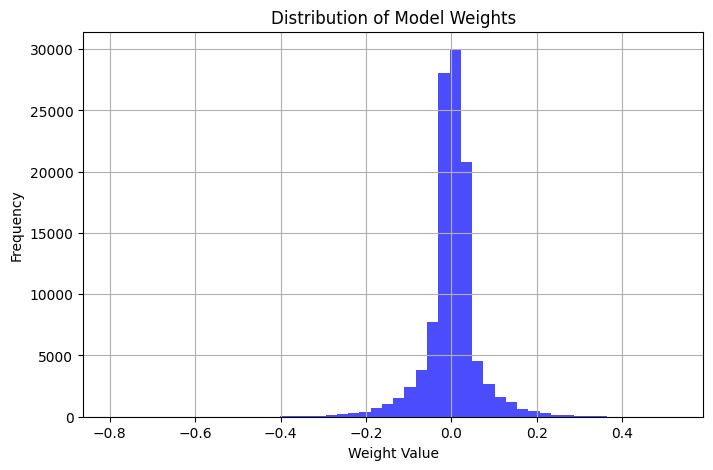

In [6]:
import matplotlib.pyplot as plt

# Get all weights as a flattened tensor
all_weights = torch.cat([param.view(-1) for name, param in model.named_parameters() if "weight" in name])
print(len(all_weights))

# Convert to NumPy for plotting
all_weights = all_weights.detach().cpu().numpy()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_weights, bins=50, alpha=0.7, color="blue")
plt.title("Distribution of Model Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


976


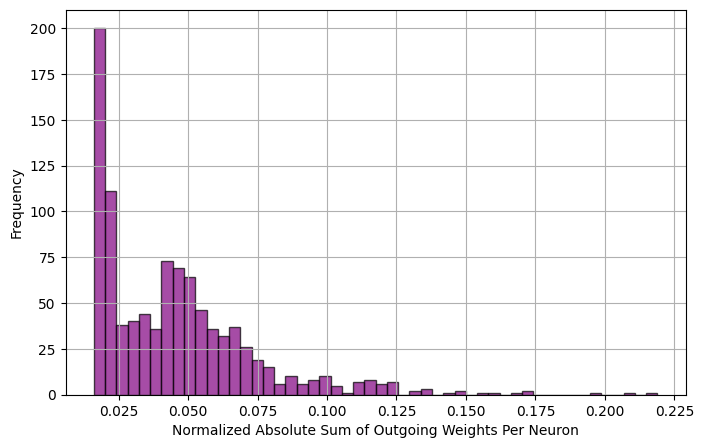

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of weights
l2_outgoing = torch.sum(torch.abs(model.l2.weight), dim=0) / model.l2.weight.size(0)
l3_outgoing = torch.sum(torch.abs(model.l3.weight), dim=0) / model.l3.weight.size(0)
l4_outgoing = torch.sum(torch.abs(model.l4.weight), dim=0) / model.l4.weight.size(0)

# Combine all values
all_outgoing_sums = np.concatenate([l2_outgoing.detach().cpu().numpy(), 
                                    l3_outgoing.detach().cpu().numpy(), 
                                    l4_outgoing.detach().cpu().numpy()])  # Total: 976 neurons
print(len(all_outgoing_sums))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_outgoing_sums, bins=50, alpha=0.7, color="purple", edgecolor="black")
plt.xlabel("Normalized Absolute Sum of Outgoing Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


202


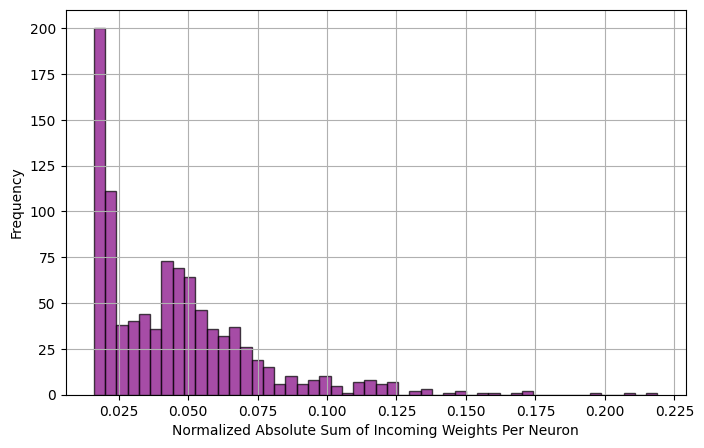

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of weights
l3_incoming = torch.sum(torch.abs(model.l3.weight), dim=1) / model.l3.weight.size(1)
l2_incoming = torch.sum(torch.abs(model.l2.weight), dim=1) / model.l2.weight.size(1)
l4_incoming = torch.sum(torch.abs(model.l4.weight), dim=1) / model.l4.weight.size(1)

# Combine all values
all_incoming_sums = np.concatenate([l2_incoming.detach().cpu().numpy(), 
                                    l3_incoming.detach().cpu().numpy(), 
                                    l4_incoming.detach().cpu().numpy()])  # Total: 976 neurons
print(len(all_incoming_sums))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_outgoing_sums, bins=50, alpha=0.7, color="purple", edgecolor="black")
plt.xlabel("Normalized Absolute Sum of Incoming Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


986


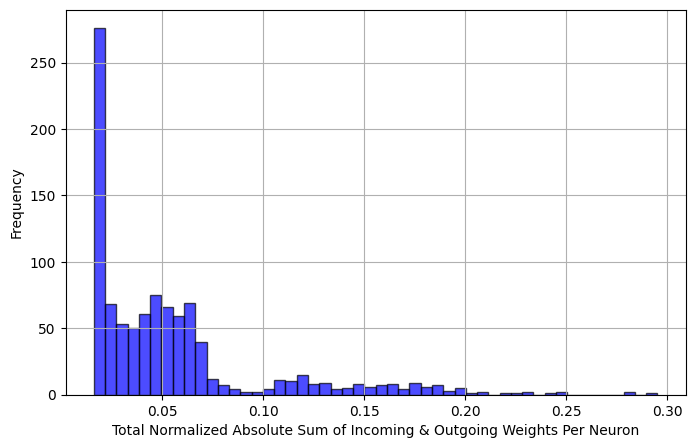

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of outgoing weights
l2_outgoing = torch.sum(torch.abs(model.l2.weight), dim=0) / model.l2.weight.size(0)  # 784 input neurons
l3_outgoing = torch.sum(torch.abs(model.l3.weight), dim=0) / model.l3.weight.size(0)  # 128 hidden neurons
l4_outgoing = torch.sum(torch.abs(model.l4.weight), dim=0) / model.l4.weight.size(0)  # 64 hidden neurons

# Compute absolute sum of incoming weights per neuron and normalize by the number of incoming weights
l2_incoming = torch.sum(torch.abs(model.l2.weight), dim=1) / model.l2.weight.size(1)  # 128 hidden neurons
l3_incoming = torch.sum(torch.abs(model.l3.weight), dim=1) / model.l3.weight.size(1)  # 64 hidden neurons
l4_incoming = torch.sum(torch.abs(model.l4.weight), dim=1) / model.l4.weight.size(1)  # 10 output neurons

# Compute total influence for each layer
l1 = l2_outgoing  # Input layer (only outgoing)
l2 = l2_incoming + l3_outgoing  # First hidden layer
l3 = l3_incoming + l4_outgoing  # Second hidden layer
l4 = l4_incoming  # Output layer (only incoming)

# Flatten and combine all values
all_total_sums = np.concatenate([
    l1.detach().cpu().numpy(),  # 784 input neurons
    l2.detach().cpu().numpy(),  # 128 first hidden neurons
    l3.detach().cpu().numpy(),  # 64 second hidden neurons
    l4.detach().cpu().numpy()   # 10 output neurons
])
print(len(all_total_sums))

# Plot histogram of total normalized absolute weights
plt.figure(figsize=(8, 5))
plt.hist(all_total_sums, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Total Normalized Absolute Sum of Incoming & Outgoing Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [44]:
import numpy as np

def round_to_sigfig(x, sig_figs=1):
    if x == 0:
        return 0  # Avoid log(0) errors
    rounded = round(x, -int(np.floor(np.log10(abs(x)))) + (sig_figs - 1))
    return float(f"{rounded:.{sig_figs}g}")  # Convert to string and back to float for precision

# Assuming all_total_sums, l2_outgoing, l2_incoming, l3_outgoing, l3_incoming, l4_outgoing, l4_incoming are already defined

# Step 1: Compute the mean of the absolute values
mean_abs = np.mean(np.abs(all_total_sums))

# Step 2: Compute abs(value) - mean for each element
modified_values = np.abs(all_total_sums) - mean_abs

# Step 3: Create a list of tuples (value, abs(value) - mean, original_index)
indexed_arr = [(val, mod_val, idx) for idx, (val, mod_val) in enumerate(zip(all_total_sums, modified_values))]

# Step 4: Sort by absolute value in descending order to determine new positions
sorted_arr = sorted(indexed_arr, key=lambda x: abs(x[0]), reverse=True)

# Step 5: Assign new positions based on sorted order
labeled_sorted_arr = [(val, mod_val, idx, rank) for rank, (val, mod_val, idx) in enumerate(sorted_arr)]

# Step 6: Convert tensors to NumPy (move to CPU first if necessary)
l2_outgoing_np = l2_outgoing.detach().cpu().numpy()
l3_outgoing_np = l3_outgoing.detach().cpu().numpy()
l4_outgoing_np = l4_outgoing.detach().cpu().numpy()
l2_incoming_np = l2_incoming.detach().cpu().numpy()
l3_incoming_np = l3_incoming.detach().cpu().numpy()
l4_incoming_np = l4_incoming.detach().cpu().numpy()

# Step 7: Flatten outgoing and incoming weight values
outgoing_weights = np.concatenate([l2_outgoing_np, l3_outgoing_np, l4_outgoing_np, np.zeros(10)])
incoming_weights = np.concatenate([np.zeros(784), l2_incoming_np, l3_incoming_np, l4_incoming_np])

# Step 8: Append the correct outgoing/incoming weights and the count of outgoing/incoming weights
final_list = []
layer_sizes = [784, 128, 64, 10]

for i, (val, mod_val, original_index, new_position) in enumerate(labeled_sorted_arr):
    # Determine the number of incoming and outgoing weights
    if original_index < 784:
        num_outgoing = 128  # Outgoing to the first hidden layer
        num_incoming = 0  # No incoming
    elif original_index < 784 + 128:
        num_outgoing = 64  # Outgoing to the second hidden layer
        num_incoming = 784  # Incoming from the first layer
    elif original_index < 784 + 128 + 64:
        num_outgoing = 10  # Outgoing to the output layer
        num_incoming = 128  # Incoming from the second hidden layer
    else:
        num_outgoing = 0  # Output layer has no outgoing
        num_incoming = 64  # Incoming from the second hidden layer

    outgoing_weight = outgoing_weights[original_index]
    incoming_weight = incoming_weights[original_index]

    final_list.append((val, mod_val, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming))

layer_labels = ["l1", "l2", "l3", "l4"]

# Function to determine the layer of a neuron based on its index
def get_layer_label(original_index):
    if original_index < layer_sizes[0]:
        return 1  # Input Layer
    elif original_index < layer_sizes[0] + layer_sizes[1]:
        return 2  # First Hidden Layer
    elif original_index < layer_sizes[0] + layer_sizes[1] + layer_sizes[2]:
        return 3  # Second Hidden Layer
    else:
        return 4

# Add a new column that stores the max between outgoing and incoming weights
final_list_sorted_with_max = [
    (
        value,
        modified_value,
        original_index,
        new_position,
        outgoing_weight,
        incoming_weight,
        num_outgoing,
        num_incoming,
        max(outgoing_weight, incoming_weight),  # New column
        get_layer_label(original_index)
    )
    for value, modified_value, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming in final_list
]

# Step 9: Sort by the new positions
final_list_sorted_with_max = sorted(final_list_sorted_with_max, key=lambda x: x[0], reverse=True)  # Sort by new_position (4th element in tuple)

# Print results
for value, modified_value, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming, max_weight, layer in final_list_sorted_with_max:
    print(f"Value: {value}, -Mean: {modified_value}, Orig: {original_index}, "
          f"New: {new_position}, Out: {outgoing_weight}, In: {incoming_weight}, "
          f"No Out: {num_outgoing}, No In: {num_incoming}, "
          f"L: {layer}, Max: {max_weight}")



Value: 0.2950665354728699, -Mean: 0.2398541420698166, Orig: 951, New: 0, Out: 0.2189006358385086, In: 0.07616589218378067, No Out: 10, No In: 128, L: 3, Max: 0.2189006358385086
Value: 0.28321224451065063, -Mean: 0.22799985110759735, Orig: 968, New: 1, Out: 0.207180455327034, In: 0.07603178918361664, No Out: 10, No In: 128, L: 3, Max: 0.207180455327034
Value: 0.280842661857605, -Mean: 0.2256302684545517, Orig: 935, New: 2, Out: 0.19836576282978058, In: 0.08247688412666321, No Out: 10, No In: 128, L: 3, Max: 0.19836576282978058
Value: 0.2502805292606354, -Mean: 0.1950681358575821, Orig: 929, New: 3, Out: 0.1723155379295349, In: 0.07796498388051987, No Out: 10, No In: 128, L: 3, Max: 0.1723155379295349
Value: 0.24774661660194397, -Mean: 0.19253422319889069, Orig: 924, New: 4, Out: 0.17361101508140564, In: 0.07413560152053833, No Out: 10, No In: 128, L: 3, Max: 0.17361101508140564
Value: 0.2423793226480484, -Mean: 0.18716692924499512, Orig: 922, New: 5, Out: 0.16964881122112274, In: 0.0727

In [12]:
# Initialize a variable to store the sum of the total number of incoming and outgoing weights
total_weight_count = 0

# Sum the total number of outgoing and incoming weights **only for rows where modified_value is negative**
for value, modified_value, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming, max_weight, layer  in final_list_sorted_with_max:
    if modified_value < 0:  # Check if modified_value is negative
        total_weight_count += num_outgoing + num_incoming

# Output the total count of incoming and outgoing weights for negative modified values
print(f"Total Count of Incoming and Outgoing Weights for Negative Values List: {total_weight_count}")


Total Count of Incoming and Outgoing Weights for Negative Values List: 83200


In [51]:
import copy

final_list_sorted_with_max = sorted(final_list_sorted_with_max, key=lambda x: x[4], reverse=True)
final_list_copy = copy.deepcopy(final_list_sorted_with_max)
final_list_copy = sorted(final_list_copy, key=lambda x: x[5], reverse=True)
con = []

def jump_layer():
    for (
        value, modified_value, original_index, new_position,
        outgoing_weight, incoming_weight, num_outgoing, num_incoming,
        max_weight, layer
    ) in final_list_sorted_with_max:
        if modified_value > 0 and layer <= 2:
            for (
                value2, modified_value2, original_index2, new_position2,
                outgoing_weight2, incoming_weight2, num_outgoing2, num_incoming2,
                max_weight2, layer2
            ) in final_list_copy:
                if modified_value2 > 0 and layer2 - layer >= 2:
                    inn = original_index2
                    innl = layer2
                    outn = original_index
                    outnl = layer
                    con.append([outn, outnl, inn, innl])
            
    #return outn, inn, outnl, innl  # Return the two values

# Example usage
# outn, inn, outnl, innl = jump_layer(final_list_sorted_with_max)
# print(f"Outn: {outn}, Outnl: {outnl}, Inn: {inn}, Innl: {innl}")
jump_layer()



In [52]:
con

[[784, 2, 977, 4],
 [784, 2, 979, 4],
 [784, 2, 982, 4],
 [784, 2, 981, 4],
 [784, 2, 983, 4],
 [784, 2, 984, 4],
 [784, 2, 985, 4],
 [784, 2, 978, 4],
 [784, 2, 980, 4],
 [784, 2, 976, 4],
 [789, 2, 977, 4],
 [789, 2, 979, 4],
 [789, 2, 982, 4],
 [789, 2, 981, 4],
 [789, 2, 983, 4],
 [789, 2, 984, 4],
 [789, 2, 985, 4],
 [789, 2, 978, 4],
 [789, 2, 980, 4],
 [789, 2, 976, 4],
 [866, 2, 977, 4],
 [866, 2, 979, 4],
 [866, 2, 982, 4],
 [866, 2, 981, 4],
 [866, 2, 983, 4],
 [866, 2, 984, 4],
 [866, 2, 985, 4],
 [866, 2, 978, 4],
 [866, 2, 980, 4],
 [866, 2, 976, 4],
 [867, 2, 977, 4],
 [867, 2, 979, 4],
 [867, 2, 982, 4],
 [867, 2, 981, 4],
 [867, 2, 983, 4],
 [867, 2, 984, 4],
 [867, 2, 985, 4],
 [867, 2, 978, 4],
 [867, 2, 980, 4],
 [867, 2, 976, 4],
 [845, 2, 977, 4],
 [845, 2, 979, 4],
 [845, 2, 982, 4],
 [845, 2, 981, 4],
 [845, 2, 983, 4],
 [845, 2, 984, 4],
 [845, 2, 985, 4],
 [845, 2, 978, 4],
 [845, 2, 980, 4],
 [845, 2, 976, 4],
 [905, 2, 977, 4],
 [905, 2, 979, 4],
 [905, 2, 98

In [53]:
len(con)

11196

In [27]:
l = f"l{outnl}"
l

'l2'

In [28]:
if outnl == 2:
    outn = outn - 784
outn

82

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128)  # Input: 784 pixels → Hidden: 128 neurons
        self.l3 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64 neurons
        self.l4 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10 (digits 0-9)

        torch.manual_seed(0)  # Set seed for reproducibility
        self.custom = nn.Parameter(torch.randn(1))  
        print(self.custom)

    def forward(self, im):
        l1 = im.view(-1, 28*28)
        l2 = F.relu(self.l2(l1))
        l3 = F.relu(self.l3(l2))
        l4 = self.l4(l3)
        if innl == 4:
            if outnl == 2:
                for i in range(len(im)): 
                    l4[i][0] = l4[i][0] + self.custom * l2[i][outn] 
        return l4

# Initialize model
model = MNIST_Net()
#model.load_state_dict(torch.load("model_weights2.pth"))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



Parameter containing:
tensor([1.5410], requires_grad=True)


MNIST_Net(
  (l2): Linear(in_features=784, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)

In [36]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights4.pth")


Epoch 1/5, Loss: 0.1574
Epoch 2/5, Loss: 0.1027
Epoch 3/5, Loss: 0.1077
Epoch 4/5, Loss: 0.1814
Epoch 5/5, Loss: 0.0789
Training complete!


In [39]:
model.custom

Parameter containing:
tensor([1.5350], device='cuda:0', requires_grad=True)

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()

        # Standard layer-to-layer feedforward connections
        self.l1_to_l2 = nn.Linear(784, 128)  # L1 → L2
        self.l2_to_l3 = nn.Linear(128, 64)   # L2 → L3
        self.l3_to_l4 = nn.Linear(64, 10)    # L3 → L4

        # Custom weights for non-adjacent connections
        self.W_l1_to_l3 = nn.Parameter(torch.randn(784, 64) * 0.01, requires_grad=True)  # L1 → L3
        self.W_l1_to_l4 = nn.Parameter(torch.randn(784, 10) * 0.01, requires_grad=True)  # L1 → L4
        self.W_l2_to_l4 = nn.Parameter(torch.randn(128, 10) * 0.01, requires_grad=True)  # L2 → L4
        print(self.W_l1_to_l3)
        print(self.W_l1_to_l4)
        print(self.W_l2_to_l4)

        # Biases for custom connections
        self.b_l1_to_l3 = nn.Parameter(torch.zeros(64))  
        self.b_l1_to_l4 = nn.Parameter(torch.zeros(10))
        self.b_l2_to_l4 = nn.Parameter(torch.zeros(10))

    def forward(self, x):
        # Flatten input image
        l1_out = x.view(-1, 784)  # L1 output

        # Compute standard layer activations
        l2_out = F.relu(self.l1_to_l2(l1_out))  # L1 → L2
        l3_out = F.relu(self.l2_to_l3(l2_out))  # L2 → L3

        # Compute long-range connections
        l3_extra = torch.matmul(l1_out, self.W_l1_to_l3) + self.b_l1_to_l3  # L1 → L3
        l4_extra = (torch.matmul(l1_out, self.W_l1_to_l4) + self.b_l1_to_l4 +
                    torch.matmul(l2_out, self.W_l2_to_l4) + self.b_l2_to_l4)  # L1 → L4 and L2 → L4

        # Combine standard activations with long-range inputs
        l3_out = F.relu(l3_out + l3_extra)  # Merge L3 standard + L1 → L3
        l4_out = self.l3_to_l4(l3_out)          # L3 → L4
        l4_out = l4_out + l4_extra          # Merge L4 standard + L1 → L4 + L2 → L4

        return l4_out  # Final output

# Initialize model
model = FullyConnectedNet()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Parameter containing:
tensor([[-0.0082, -0.0199, -0.0177,  ..., -0.0109,  0.0184,  0.0180],
        [-0.0008,  0.0141, -0.0162,  ..., -0.0045, -0.0125,  0.0156],
        [-0.0113, -0.0033, -0.0094,  ..., -0.0032,  0.0186, -0.0031],
        ...,
        [-0.0074, -0.0164, -0.0057,  ..., -0.0058,  0.0047,  0.0087],
        [-0.0033,  0.0038, -0.0056,  ...,  0.0011,  0.0150, -0.0089],
        [-0.0031, -0.0144, -0.0034,  ..., -0.0019,  0.0073, -0.0024]],
       requires_grad=True)
Parameter containing:
tensor([[ 6.1572e-03, -1.1490e-02, -5.6214e-03,  ...,  8.5687e-03,
          7.4765e-03, -1.8061e-03],
        [-1.4076e-03, -1.0360e-03,  8.5654e-03,  ...,  4.0295e-03,
         -1.2118e-02,  1.1310e-02],
        [ 3.5902e-03, -1.6468e-03,  1.2314e-02,  ...,  7.8538e-04,
          8.3360e-03, -9.1726e-04],
        ...,
        [ 2.9837e-03,  3.0208e-03, -3.8354e-03,  ...,  5.4511e-03,
         -4.4792e-03, -4.6634e-03],
        [-8.5227e-05,  8.3881e-04,  1.2722e-02,  ...,  2.2137e-03,
   

FullyConnectedNet(
  (l1_to_l2): Linear(in_features=784, out_features=128, bias=True)
  (l2_to_l3): Linear(in_features=128, out_features=64, bias=True)
  (l3_to_l4): Linear(in_features=64, out_features=10, bias=True)
)

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def remove_neurons_from_layer(layer, neurons_to_remove):
    """
    Removes specified neurons from a given fully connected layer.
    
    Args:
        layer (nn.Linear): The original layer to modify.
        neurons_to_remove (list): List of neuron indices to remove.

    Returns:
        nn.Linear: A new layer with the specified neurons removed.
    """
    neurons_to_remove = sorted(neurons_to_remove)

    # Extract current weights and biases
    old_weights = layer.weight.detach().clone()
    old_bias = layer.bias.detach().clone()

    # Create a mask to keep only the rows we want
    keep_indices = [i for i in range(old_weights.shape[0]) if i not in neurons_to_remove]

    # Remove the specified rows
    new_weights = old_weights[keep_indices, :]
    new_bias = old_bias[keep_indices]

    # Create new Linear layer with adjusted output size
    new_layer = nn.Linear(layer.in_features, len(keep_indices), bias=True)

    # Copy the modified weights and biases into the new layer
    with torch.no_grad():
        new_layer.weight.copy_(new_weights)
        new_layer.bias.copy_(new_bias)

    return new_layer


class CustomNet(nn.Module):
    def __init__(self, input_size=784, remove_pixels=[], remove_neurons=[]):
        super(CustomNet, self).__init__()

        self.remove_pixels = sorted(remove_pixels)  # Store pixels to remove
        self.remove_neurons = sorted(remove_neurons)  # Store neurons to remove

        # **Step 1: Remove specified neurons from the first hidden layer (l1)**
        self.l1 = nn.Linear(input_size - len(self.remove_pixels), 128)  # Adjusted input size
        self.l1 = remove_neurons_from_layer(self.l1, self.remove_neurons)  # Apply neuron removal
        print(self.l1.weight.shape)

        # **Step 2: Define next layers after neuron removal is applied**
        self.l2 = nn.Linear(self.l1.out_features, 64)  # l2 takes the output from l1
        self.l3 = nn.Linear(self.l2.out_features, 10)  # l3 takes the output from l2

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input (batch_size, 784)

        # **Step 1: Remove selected pixels from input layer**
        if self.remove_pixels:
            keep_indices = [i for i in range(784) if i not in self.remove_pixels]
            x = x[:, keep_indices]  # Keep only non-removed pixels
            print(x.shape)

        # **Step 2: Forward pass through the network**
        l1_out = F.relu(self.l1(x))
        l2_out = F.relu(self.l2(l1_out))
        l3_out = self.l3(l2_out)

        return l3_out


# Example: Removing input pixels (100, 200, 300) and neurons (10, 20, 42) from layer l1
pixels_to_remove = [100, 200, 300]
neurons_to_remove = [10, 20, 42]

# Initialize model with adjusted input size and neurons removed
model = CustomNet(remove_pixels=pixels_to_remove, remove_neurons=neurons_to_remove)

# Example batch of images (batch_size = 64, image_size = 28x28 → flattened to 784)
x = torch.randn(64, 784)

# Forward pass
output = model(x)


torch.Size([125, 781])
torch.Size([64, 781])
